## Importing Libraries


In [1]:
#supress warnings
import warnings
warnings.filterwarnings('ignore')

#numpy and pandas for data manipulation
import pandas as pd
import numpy as np
import xgboost as xg
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#matplotlib and seaborn for data visualization
import matplotlib.pyplot as plt

#file system management
import os

## Reading the dataset


In [2]:
df = pd.read_csv('./data/monatszahlen2209_verkehrsunfaelle.csv')
df.head()

MONATSZAHL AUSPRÄGUNG  JAHR   MONAT  WERT  VORJAHRESWERT  \
0  Alkoholunfälle  insgesamt  2022  202201   NaN           16.0   
1  Alkoholunfälle  insgesamt  2022  202202   NaN           14.0   
2  Alkoholunfälle  insgesamt  2022  202203   NaN           24.0   
3  Alkoholunfälle  insgesamt  2022  202204   NaN           16.0   
4  Alkoholunfälle  insgesamt  2022  202205   NaN           24.0   

   VERÄND_VORMONAT_PROZENT  VERÄND_VORJAHRESMONAT_PROZENT  \
0                      NaN                            NaN   
1                      NaN                            NaN   
2                      NaN                            NaN   
3                      NaN                            NaN   
4                      NaN                            NaN   

   ZWÖLF_MONATE_MITTELWERT  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN

In [3]:
df.isnull().sum()

MONATSZAHL                         0
AUSPRÄGUNG                         0
JAHR                               0
MONAT                              0
WERT                              84
VORJAHRESWERT                     91
VERÄND_VORMONAT_PROZENT          246
VERÄND_VORJAHRESMONAT_PROZENT    176
ZWÖLF_MONATE_MITTELWERT          238
dtype: int64

## Preprocessing the dataset


In [4]:
# As mentioned, only first 5 columns are important
df = df.iloc[:,:5]
df.head()

MONATSZAHL AUSPRÄGUNG  JAHR   MONAT  WERT
0  Alkoholunfälle  insgesamt  2022  202201   NaN
1  Alkoholunfälle  insgesamt  2022  202202   NaN
2  Alkoholunfälle  insgesamt  2022  202203   NaN
3  Alkoholunfälle  insgesamt  2022  202204   NaN
4  Alkoholunfälle  insgesamt  2022  202205   NaN

In [5]:
# Dropping data that comes after 2020
df = df[(df.JAHR <= 2020) ]
df.head()

MONATSZAHL AUSPRÄGUNG  JAHR   MONAT   WERT
25  Alkoholunfälle  insgesamt  2020   Summe  430.0
26  Alkoholunfälle  insgesamt  2020  202001   28.0
27  Alkoholunfälle  insgesamt  2020  202002   40.0
28  Alkoholunfälle  insgesamt  2020  202003   27.0
29  Alkoholunfälle  insgesamt  2020  202004   26.0

## Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1911 entries, 25 to 2085
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MONATSZAHL  1911 non-null   object 
 1   AUSPRÄGUNG  1911 non-null   object 
 2   JAHR        1911 non-null   int64  
 3   MONAT       1911 non-null   object 
 4   WERT        1911 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 89.6+ KB


In [7]:
# percentage of data which is null in each column
(df.isna().sum() / df.shape[0]) * 100

MONATSZAHL    0.0
AUSPRÄGUNG    0.0
JAHR          0.0
MONAT         0.0
WERT          0.0
dtype: float64

In [8]:
df["WERT"].describe()

count     1911.000000
mean      1440.540031
std       4655.514611
min          0.000000
25%         41.000000
50%        399.000000
75%        864.000000
max      46988.000000
Name: WERT, dtype: float64

In [9]:
df["MONAT"].describe()

count      1911
unique      253
top       Summe
freq        147
Name: MONAT, dtype: object

In [10]:
df["JAHR"].describe()

count    1911.000000
mean     2010.000000
std         6.056886
min      2000.000000
25%      2005.000000
50%      2010.000000
75%      2015.000000
max      2020.000000
Name: JAHR, dtype: float64

In [11]:
df["AUSPRÄGUNG"].unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

In [12]:
df["MONATSZAHL"].unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [13]:
# Creating new_df for statistical analysis
new_df = df[['MONAT','WERT']]
new_df.head()

MONAT   WERT
25   Summe  430.0
26  202001   28.0
27  202002   40.0
28  202003   27.0
29  202004   26.0

In [14]:
new_df = new_df.reset_index(drop=True)

In [15]:
new_df.head()

MONAT   WERT
0   Summe  430.0
1  202001   28.0
2  202002   40.0
3  202003   27.0
4  202004   26.0

## EXploratory data analysis


In [16]:
"""
Category Types :
Alkoholunf√§lle -> 0
Fluchtunf√§lle -> 1
Verkehrsunf√§lle -> 2

Accident Types :
insgesamt -> 0
mit Personensch√§den -> 1
Verletzte und Get√∂tete -> 2
"""

'\nCategory Types :\nAlkoholunf√§lle -> 0\nFluchtunf√§lle -> 1\nVerkehrsunf√§lle -> 2\n\nAccident Types :\ninsgesamt -> 0\nmit Personensch√§den -> 1\nVerletzte und Get√∂tete -> 2\n'

In [17]:
"""
MONATSZAHL -> Category

AUSPRÄGUNG -> Accident Type (insgesamt means total for all subcategories)

JAHR -> Year

MONAT -> Month

WERT -> Value

"""

'\nMONATSZAHL -> Category\n\nAUSPRÄGUNG -> Accident Type (insgesamt means total for all subcategories)\n\nJAHR -> Year\n\nMONAT -> Month\n\nWERT -> Value\n\n'

         MONATSZAHL AUSPRÄGUNG  JAHR  MONAT   WERT
25   Alkoholunfälle  insgesamt  2020  Summe  430.0
38   Alkoholunfälle  insgesamt  2019  Summe  434.0
51   Alkoholunfälle  insgesamt  2018  Summe  398.0
64   Alkoholunfälle  insgesamt  2017  Summe  409.0
77   Alkoholunfälle  insgesamt  2016  Summe  301.0
90   Alkoholunfälle  insgesamt  2015  Summe  411.0
103  Alkoholunfälle  insgesamt  2014  Summe  382.0
116  Alkoholunfälle  insgesamt  2013  Summe  377.0
129  Alkoholunfälle  insgesamt  2012  Summe  440.0
142  Alkoholunfälle  insgesamt  2011  Summe  397.0
155  Alkoholunfälle  insgesamt  2010  Summe  402.0
168  Alkoholunfälle  insgesamt  2009  Summe  430.0
181  Alkoholunfälle  insgesamt  2008  Summe  482.0
194  Alkoholunfälle  insgesamt  2007  Summe  560.0
207  Alkoholunfälle  insgesamt  2006  Summe  599.0
220  Alkoholunfälle  insgesamt  2005  Summe  600.0
233  Alkoholunfälle  insgesamt  2004  Summe  659.0
246  Alkoholunfälle  insgesamt  2003  Summe  730.0
259  Alkoholunfälle  insgesamt 

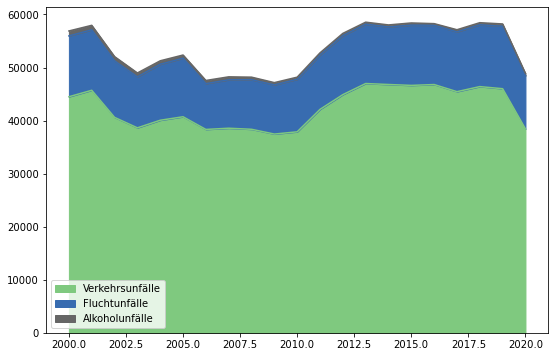

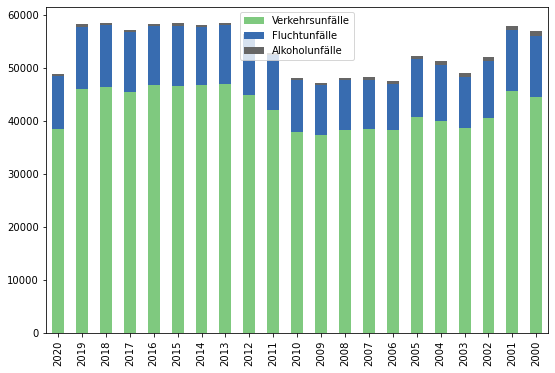

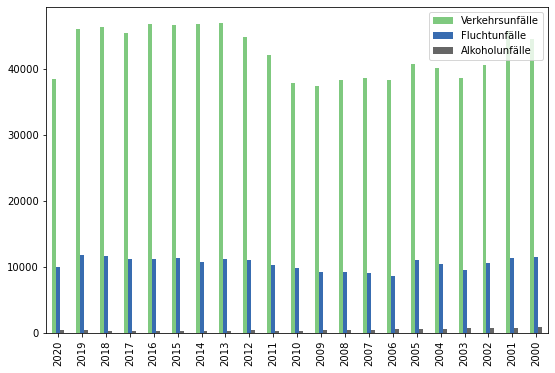

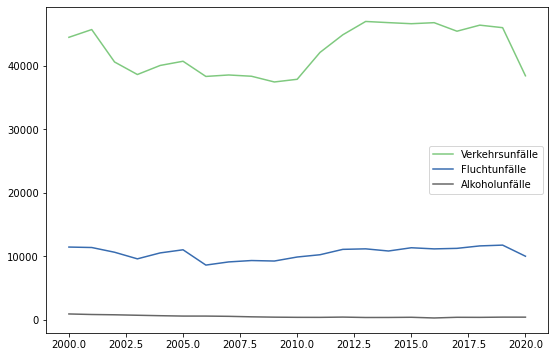

In [18]:
# Data Visualization

accidents = df[df['JAHR'] < 2021]

Verkehrsunfälle = accidents[(
    (accidents['MONATSZAHL'] == 'Verkehrsunfälle') &
    (accidents['MONAT'] == 'Summe') &
    (accidents['AUSPRÄGUNG'] == 'insgesamt')
    )]
Fluchtunfälle = accidents[(
    (accidents['MONATSZAHL'] == 'Fluchtunfälle') &
    (accidents['MONAT'] == 'Summe') &
    (accidents['AUSPRÄGUNG'] == 'insgesamt')
    )]
Alkoholunfälle = accidents[(
    (accidents['MONATSZAHL'] == 'Alkoholunfälle') &
    (accidents['MONAT'] == 'Summe') &
    (accidents['AUSPRÄGUNG'] == 'insgesamt')
    )]
print(Alkoholunfälle)
years = [i for i in range(2000, 2021)]
years.sort(reverse=True)

accidents_category = pd.DataFrame({
        "Verkehrsunfälle": Verkehrsunfälle['WERT'].to_numpy(),
        "Fluchtunfälle": Fluchtunfälle['WERT'].to_numpy(),
        "Alkoholunfälle": Alkoholunfälle['WERT'].to_numpy()
    },
    index= years
)

accidents_category.plot(kind='area',colormap='Accent',)
plt.gcf().set_size_inches(9,6)
accidents_category.plot(kind='bar', colormap='Accent', stacked= True)
plt.gcf().set_size_inches(9,6)
accidents_category.plot(kind='bar', colormap='Accent')
plt.gcf().set_size_inches(9,6)
accidents_category.plot(colormap='Accent')
plt.gcf().set_size_inches(9,6)

In [19]:
# # Remove the 'Summe' from Month column 
# df = df[df['MONAT'] != 'Summe']

# Monat has only 147 summe so removing them
lst = ['Summe']
df = df[df.MONAT.isin(lst) == False]

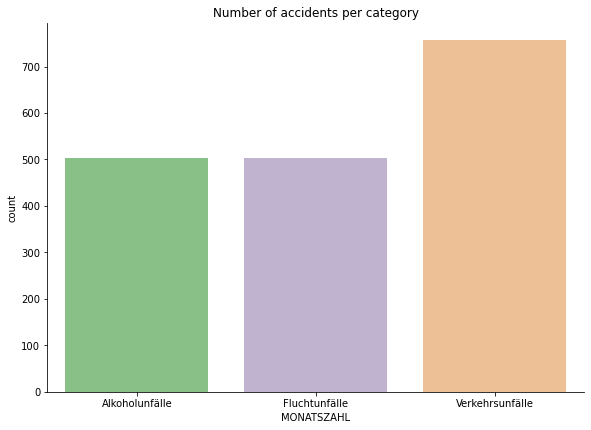

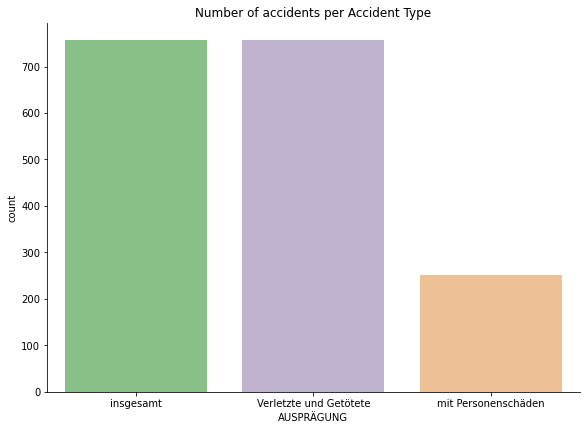

In [20]:
# Plot Number of accidents per category
plot = sns.catplot(x="MONATSZAHL", kind="count", data=df, palette="Accent")
plt.title('Number of accidents per category')
plt.gcf().set_size_inches(9,6)

# Plot Number of accidents per Accident Type
plot = sns.catplot(x="AUSPRÄGUNG", kind="count", data=df, palette="Accent")
plt.title('Number of accidents per Accident Type')
plt.gcf().set_size_inches(9,6)

In [21]:
df.tail()

MONATSZAHL              AUSPRÄGUNG  JAHR   MONAT   WERT
2081  Verkehrsunfälle  Verletzte und Getötete  2000  200008  647.0
2082  Verkehrsunfälle  Verletzte und Getötete  2000  200009  675.0
2083  Verkehrsunfälle  Verletzte und Getötete  2000  200010  615.0
2084  Verkehrsunfälle  Verletzte und Getötete  2000  200011  578.0
2085  Verkehrsunfälle  Verletzte und Getötete  2000  200012  515.0

In [22]:
df.shape

(1764, 5)

In [23]:
df = df.reset_index()

In [24]:
df = df.drop(columns=['index'])

In [25]:
df.tail()

MONATSZAHL              AUSPRÄGUNG  JAHR   MONAT   WERT
1759  Verkehrsunfälle  Verletzte und Getötete  2000  200008  647.0
1760  Verkehrsunfälle  Verletzte und Getötete  2000  200009  675.0
1761  Verkehrsunfälle  Verletzte und Getötete  2000  200010  615.0
1762  Verkehrsunfälle  Verletzte und Getötete  2000  200011  578.0
1763  Verkehrsunfälle  Verletzte und Getötete  2000  200012  515.0

## Feature engineering

In [26]:
# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit and transform the data to label encode the categories
data_encoded_1 = le.fit_transform(df['AUSPRÄGUNG'])
data_encoded_2 = le.fit_transform(df['MONATSZAHL'])

df.drop(columns=['AUSPRÄGUNG','MONATSZAHL'])
df['AUSPRÄGUNG'] = pd.DataFrame(data_encoded_1)
df['MONATSZAHL'] = pd.DataFrame(data_encoded_2)

df.head()


MONATSZAHL  AUSPRÄGUNG  JAHR   MONAT  WERT
0           0           1  2020  202001  28.0
1           0           1  2020  202002  40.0
2           0           1  2020  202003  27.0
3           0           1  2020  202004  26.0
4           0           1  2020  202005  40.0

In [27]:
def func(x):
    return int(x[-2:])

df['MONAT'] = df['MONAT'].apply(func)

df.head()

MONATSZAHL  AUSPRÄGUNG  JAHR  MONAT  WERT
0           0           1  2020      1  28.0
1           0           1  2020      2  40.0
2           0           1  2020      3  27.0
3           0           1  2020      4  26.0
4           0           1  2020      5  40.0

In [28]:
df = df.reset_index()
df.tail()

index  MONATSZAHL  AUSPRÄGUNG  JAHR  MONAT   WERT
1759   1759           2           0  2000      8  647.0
1760   1760           2           0  2000      9  675.0
1761   1761           2           0  2000     10  615.0
1762   1762           2           0  2000     11  578.0
1763   1763           2           0  2000     12  515.0

In [29]:
df.isnull().sum()

index         0
MONATSZAHL    0
AUSPRÄGUNG    0
JAHR          0
MONAT         0
WERT          0
dtype: int64

In [30]:
# Final Pipeline
X = df[['MONATSZAHL','AUSPRÄGUNG','JAHR','MONAT']].values
y = df[['WERT']].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [32]:
X

array([[   0,    1, 2020,    1],
       [   0,    1, 2020,    2],
       [   0,    1, 2020,    3],
       ...,
       [   2,    0, 2000,   10],
       [   2,    0, 2000,   11],
       [   2,    0, 2000,   12]], dtype=int64)

In [33]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1587
1587
177
177


## Linear Regression

In [34]:
regressor_df = LinearRegression()
regressor_df.fit(X_train, y_train)

y_hat = regressor_df.predict(X_test)
rmse = mean_squared_error(y_test,y_hat, squared=False)
print("RMSE : % f" %(rmse))

RMSE :  930.768554


## XGBoost

In [35]:
xgb_df = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_df.fit(X_train, y_train)
  
# Predict the model
y_hat = xgb_df.predict(X_test)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_test, y_hat, squared=False))
print("RMSE : % f" %(rmse))

[15:04:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  10.368308


In [36]:
print(list(y_test))
print(list(y_hat))

[array([2643.]), array([797.]), array([39.]), array([1095.]), array([3529.]), array([510.]), array([3315.]), array([57.]), array([490.]), array([515.]), array([35.]), array([85.]), array([277.]), array([49.]), array([78.]), array([27.]), array([591.]), array([560.]), array([51.]), array([34.]), array([3500.]), array([935.]), array([58.]), array([301.]), array([595.]), array([306.]), array([3387.]), array([40.]), array([24.]), array([43.]), array([3789.]), array([2749.]), array([832.]), array([412.]), array([31.]), array([620.]), array([4027.]), array([39.]), array([37.]), array([58.]), array([997.]), array([29.]), array([3730.]), array([355.]), array([820.]), array([441.]), array([41.]), array([370.]), array([3206.]), array([61.]), array([778.]), array([58.]), array([462.]), array([439.]), array([25.]), array([3565.]), array([71.]), array([793.]), array([38.]), array([3888.]), array([36.]), array([254.]), array([713.]), array([31.]), array([17.]), array([35.]), array([500.]), array([47

In [37]:
!pip install fbprophet


^C


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pystan-3.6.0-py3-none-any.whl (13 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached pysimdjson-5.0.2-cp39-cp39-win_amd64.whl (156 kB)
  Using cached pystan-3.5.0-py3-none-any.whl (13 kB)
  Using cached pysimdjson-3.2.0-cp39-cp39-win_amd64.whl (157 kB)
  Using cached pystan-3.4.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.3.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.2.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.1.1-py3-none-any.whl (13 kB)
  Using cached pystan-3.1.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.0.2-py3-none-any.whl (13 kB)
  Using cached pystan-3.0.1-py3-none-any.whl (12 kB)
  Using cached pystan-3.0.0-py3-none-any.whl (12 kB)
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib
      creating build\lib\fbprophet
      creating build\lib\fbprophet\stan_model
      NumExpr defaulting to 8 threads.
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\bisht\AppData\Local\Temp\pip-install-50q69axm\fbprophet_b19f11fdeacf4109b6459f9f6255c2cf\setup.py", line 122, in <module>
          setup(
        File "C:\Users\bisht\anaconda3\lib\site-packages\setuptools\__init__.py", line 87, in setup
          return distutils.core.setup(**attrs)
        File "C:\Users\bisht\anaconda3\lib\site-packages\setuptools\_distutils\core.py", line 148, in setup
          return run_commands(dist)
        File "C:\Users

In [ ]:
!pip install pystan==2.19.1.1

: 

## Facebook Prophet

In [ ]:
print(fbprophet.__version__)


: 

In [ ]:
import fbprophet


: 

In [ ]:
m = fbprophet.Prophet()

: 

In [ ]:
import pkg_resources
model_file = pkg_resources.resource_filename('fbprophet', 'stan_model/prophet_model.pkl')
print(model_file)

: 

In [ ]:
import pystan
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0

: 

the dataset looks stationary, We can choose ARIMA Model for forecasting no. of accidents, but we need to conduct the test for stationarity

# Checking For Stationarity

In [ ]:
# from statsmodels.tsa.stattools import adfuller

# def ad_test(dataset):
#      dftest = adfuller(dataset, autolag = 'AIC')
#      print("1. ADF : ",dftest[0])
#      print("2. P-Value : ", dftest[1])
#      print("3. Num Of Lags : ", dftest[2])
#      print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
#      print("5. Critical Values :")
#      for key, val in dftest[4].items():
#          print("\t",key, ": ", val)

# ad_test(new_df['AvgTemp'])

: 

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# def convert_categorical(columnname, dataframe):
    
#     dummy_df = pd.get_dummies(dataframe[columnname], prefix=columnname)

#     merged_df = pd.concat([dataframe, dummy_df], axis=1)

#     merged_df = merged_df.drop(columnname, axis=1)

#     return merged_df



: 

In [ ]:
# df = convert_categorical('AUSPRÄGUNG',df)
# df.head()

: 

In [ ]:
# df = convert_categorical('MONATSZAHL',df)
# df.head()

: 

In [ ]:
new_df.shape

: 

In [ ]:
from autots import AutoTS, load_monthly
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# new_df = load_monthly(long = False)

# y = df['WERT']

# X = df.drop('WERT', axis = 1)

: 

In [ ]:
new_df.columns = ['datetime','value']

: 

In [ ]:
new_df['datetime'] = pd.to_datetime(new_df['datetime'],format='%Y%m')
new_df.head()

: 

In [ ]:
# new_df = new_df.set_index('datetime')

: 

In [ ]:
new_df.head()

: 

In [ ]:
# split data into training and testing sets
train_data = new_df.iloc[:1700,:]
test_data = new_df.iloc[1700:,:]
train_data.head()

: 

: 

: 

In [ ]:
# create AutoTS model
model = AutoTS(forecast_length=len(test_data), frequency='infer', ensemble='all')

# fit model to training data
model.fit(train_data, date_col='datetime', value_col='value')

: 

In [ ]:
# make predictions on test data
predictions = model.predict()

# calculate mean absolute error (MAE)
mae = abs(predictions['Value'] - test_data['Value']).mean()

# print MAE
print('Mean Absolute Error:', mae)

: 

: 